In [108]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression, TweedieRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from imblearn.under_sampling import AllKNN
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced

import optuna

random_seed = 519825
test_size = 0.3
val_size = 0.3

#### Data import

In [4]:
data_path = os.path.join(os.getcwd(), 'gym_churn_us.csv')
df = pd.read_csv(data_path)

#### Model selection
- Random uniform
- Multi-linear regression / logistic regression / Ridge or SGD
- Linear mixed models
- Generalized linear models
- Naive bayes classifier
- Gaussian processes
- Random forest classifier
- Support vector classifier
- Boosting algorithms
- K-NN classifier
- Multilayer perceptron

#### Feature engineering

In [5]:
df2 = df.copy()
df2['Prop_contract_remaining'] = df2['Month_to_end_contract'] / df2['Contract_period']
df2['Perchg_class_freq_curr_month_to_total'] = (df2['Avg_class_frequency_current_month'] / df2['Avg_class_frequency_total']) - 1
df2['Perchg_class_freq_curr_month_to_total'] = np.where(df2['Perchg_class_freq_curr_month_to_total'] == np.inf, df2['Avg_class_frequency_current_month'], df2['Perchg_class_freq_curr_month_to_total'])
df2['Perchg_class_freq_curr_month_to_total'].fillna(0, inplace=True)
df2.drop(['Month_to_end_contract', 'Contract_period', 'Avg_class_frequency_current_month', 'Avg_class_frequency_total'], axis=1, inplace=True)

ct = ColumnTransformer([
        ('avg_add_chrg_ss', StandardScaler(), ['Avg_additional_charges_total']),
        ('pchg_curr_mth_ttl_ss', StandardScaler(), ['Perchg_class_freq_curr_month_to_total']), 
        ('age_mm', MinMaxScaler(), ['Age'])
    ], remainder='passthrough')
df3 = pd.DataFrame(ct.fit_transform(df2), columns=[col.split('__')[0] if col.split('__')[0] != 'remainder' else col.split('__')[1] for col in ct.get_feature_names_out()])

#### Model set-up
- Create training & testing sets (rebalance with SMOTE)
- Set-up metrics

In [77]:
def run_metrics(model, X_eval, y_eval, add_info='', resampled=True):
    # metrics
    data = {
        'classifier': [model.__class__.__name__],
        'add_info': [add_info],
        'accuracy': [accuracy_score(y_eval, model.predict(X_eval))],
        'auc': [roc_auc_score(y_eval, model.predict(X_eval))],
    }
    
    # classification report
    if resampled:
        rep_stats = classification_report_imbalanced(y_eval, model.predict(X_eval), output_dict=True)
    else:
        rep_stats = classification_report(y_eval, model.predict(X_eval), output_dict=True)
    df_cr = pd.DataFrame.from_dict(rep_stats)
    df_cr['classifier'] = model.__class__.__name__
    df_cr['add_info'] = add_info
    
    # confusion matrix
    df_cm = pd.DataFrame(confusion_matrix(y_eval, model.predict(X_eval)))
    df_cm['classifier'] = model.__class__.__name__
    df_cm['add_info'] = add_info
    
    return (pd.DataFrame.from_dict(data), df_cm, df_cr)

create_val_dataset = False

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(df3.drop('Churn', axis=1), df3['Churn'])
print('Original (0, 1): ', df3['Churn'].value_counts().values, '\nResampled (0,1): ', y_resampled.value_counts().values)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=test_size, random_state=random_seed, stratify=y_resampled)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

if create_val_dataset:
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_size/(test_size + val_size), random_state=random_seed, stratify=y_test)
    print('X_val shape:', X_val.shape)
    print('y_val shape:', y_val.shape)
    
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

Original (0, 1):  [2939 1061] 
Resampled (0,1):  [2939 2939]
X_train shape: (4114, 11)
X_val shape: (882, 11)
X_test shape: (882, 11)
y_train shape: (4114,)
y_val shape: (882,)
y_test shape: (882,)


#### Base classifier

In [78]:
metrics_list, cm_list, cr_list = list(), list(), list()

In [79]:
dc_most_frq, dc_uniform = DummyClassifier(strategy='most_frequent'), DummyClassifier(strategy='uniform', random_state=random_seed)
dc_most_frq.fit(X_train, y_train)
dc_uniform.fit(X_train, y_train)

base_most_frq_metrics, base_most_frq_cm, base_most_frq_cr = run_metrics(dc_most_frq, X_test, y_test, add_info='most_frequent')
base_uniform_metrics, base_uniform_cm, base_uniform_cr = run_metrics(dc_uniform, X_test, y_test, add_info='uniform')

metrics_list.append(base_most_frq_metrics)
metrics_list.append(base_uniform_metrics)
cm_list.append(base_most_frq_cm)
cm_list.append(base_uniform_cm)
cr_list.append(base_most_frq_cr)
cr_list.append(base_uniform_cr)

/Users/jerryli/Documents/Virtual Environments/general/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Optuna run

In [242]:
model_dict = {
    'Ridge': RidgeClassifier,
    'SGD': SGDClassifier,
    'LogisticRegression': LogisticRegression,
    'KNeighbors': KNeighborsClassifier,
    'GaussianProcess': GaussianProcessClassifier,
    # 'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis,
    'GaussianNB': GaussianNB,
    'BernoulliNB': BernoulliNB,
    'MLP': MLPClassifier,
    'LinearSVC': LinearSVC,
    'NuSVC': NuSVC,
    'ExtraTrees': ExtraTreesClassifier,
    'RandomForest': RandomForestClassifier,
    'AdaBoost': AdaBoostClassifier,
    'GradientBoost': GradientBoostingClassifier
}

In [259]:
def objective(trial, X_train=X_train, y_train=y_train.values, X_test=X_test, y_test=y_test.values, model_dict=model_dict):
    classifier_name = trial.suggest_categorical("classifier", list(model_dict.keys()))
    _classifier_obj = model_dict.get(classifier_name, None)
    assert _classifier_obj is not None, 'No classifier stored in model dictionary'
    match classifier_name:
        case "Ridge":
            alpha = trial.suggest_float("alpha", 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"])
            classifier_obj = _classifier_obj(alpha=alpha, solver=solver, random_state=random_seed)
        case "SGD":
            loss = trial.suggest_categorical("loss", ['log', 'perceptron'])
            penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
            alpha = trial.suggest_float("alpha", 1e-3, 1e2, log=True)
            l1_ratio = trial.suggest_float("l1_ratio", 1e-3, 1, log=True)
            episilon = trial.suggest_float("epsilon", 1e-3, 1e2, log=True)
            eta = trial.suggest_float("eta0", 1e-3, 1e2, log=True)
            power_t = trial.suggest_float("power_t", 1e-3, 1e2, log=True)
            classifier_obj = _classifier_obj(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, epsilon=episilon, eta0=eta, power_t=power_t, random_state=random_seed)
        case "LogisticRegression":
            # penalty = trial.suggest_categorical("penalty", ['l1', 'l2', 'elasticnet'])
            # solver = trial.suggest_categorical("solver", ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
            C = trial.suggest_float("C", 1e-5, 1, log=True)
            classifier_obj = _classifier_obj(
                # penalty=penalty, 
                # solver=solver, 
                C=C, 
                random_state=random_seed
            )
        case "KNeighbors":
            n_neighbors = trial.suggest_int("n_neighbors", 1, 100)
            weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
            algorithm = trial.suggest_categorical("algorithm", ['ball_tree', 'kd_tree', 'brute'])
            leaf_size = trial.suggest_int("leaf_size", 10, 100)
            p = trial.suggest_int("p", 1, 10)
            classifier_obj = _classifier_obj(n_neighbors=n_neighbors, 
                                             weights=weights, 
                                             algorithm=algorithm, 
                                             leaf_size=leaf_size, 
                                             p=p,
                                             n_jobs=-1)
        case "GaussianProcess":
            optimizer = trial.suggest_categorical("optimizer", ['fmin_l_bfgs_b'])
            n_restarts_optimizer = trial.suggest_int("n_restarts_optimizer", 0, 10)
            max_iter_predict = trial.suggest_int("max_iter_predict", 10, 100)
            classifier_obj = _classifier_obj(optimizer=optimizer, n_restarts_optimizer=n_restarts_optimizer, max_iter_predict=max_iter_predict, random_state=random_seed, n_jobs=-1)
        # case "LinearDiscriminantAnalysis":
            # solver = trial.suggest_categorical("solver", ['lsqr', 'eigen'])
            # shrinkage = trial.suggest_float("shrinkage", 0, 1)
            # classifier_obj = _classifier_obj(
                # solver=solver, 
                # shrinkage=shrinkage if solver != 'svd' else None
            # )
        case "GaussianNB":
            var_smoothing = trial.suggest_float("var_smoothing", 1e-9, 1e-3, log=True)
            classifier_obj = _classifier_obj(var_smoothing=var_smoothing)
        case "BernoulliNB":
            alpha = trial.suggest_float("alpha", 1e-3, 1e2, log=True)
            classifier_obj = _classifier_obj(alpha=alpha)
        case "MLP":
            hidden_layer_sizes = trial.suggest_int("hidden_layer_sizes", 10, 500)
            activation = trial.suggest_categorical("activation", ['relu', 'identity', 'logistic', 'tanh'])
            # solver = trial.suggest_categorical("solver", ['lbfgs', 'sgd'])
            alpha = trial.suggest_float("alpha", 1e-5, 1e2, log=True)
            batch_size = trial.suggest_int("batch_size", 200, 400)
            # learning_rate = trial.suggest_categorical("learning_rate", ['constant', 'invscaling', 'adaptive']) if solver == 'sgd' else 'constant'
            learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e2, log=True)
            power_t = trial.suggest_float("power_t", 1e-5, 1e2, log=True)
            max_iter = trial.suggest_int("max_iter", 200, 500)
            momentum = trial.suggest_float("momentum", 0.0, 1.0)
            validation_fraction = trial.suggest_float("validation_fraction", 0.0, 0.3)
            beta_1 = trial.suggest_float("beta_1", 0.9, 0.9999, log=True)
            beta_2 = trial.suggest_float("beta_2", 0.9, 0.9999, log=True)
            epsilon = trial.suggest_float("epsilon", 1e-8, 1e-2, log=True)
            classifier_obj = _classifier_obj(hidden_layer_sizes=hidden_layer_sizes, 
                                             activation=activation, 
                                            #  solver=solver, 
                                             alpha=alpha, 
                                             batch_size=batch_size,
                                            #  learning_rate=learning_rate, 
                                             learning_rate_init=learning_rate_init, 
                                             power_t=power_t, 
                                             max_iter=max_iter, 
                                             momentum=momentum, 
                                             validation_fraction=validation_fraction, 
                                             beta_1=beta_1, 
                                             beta_2=beta_2, 
                                             epsilon=epsilon,
                                             early_stopping=True, 
                                             shuffle=False)
        case "LinearSVC":
            # penalty = trial.suggest_categorical("penalty", ['l1', 'l2'])
            # loss = trial.suggest_categorical("loss", ['squared_hinge'])
            tol = trial.suggest_float("tol", 1e-5, 1e-1, log=True)
            C = trial.suggest_float("C", 1e-3, 1e2, log=True)
            classifier_obj = _classifier_obj(
                # penalty=penalty, 
                # loss=loss, 
                tol=tol, 
                C=C, 
                dual=False)
        case "NuSVC":
            nu = trial.suggest_float("nu", 0.5, 1.0)
            kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'])
            degree = trial.suggest_int("degree", 2, 5)
            gamma = trial.suggest_categorical("gamma", ['scale', 'auto'])
            coef0 = trial.suggest_float("coef0", 0.0, 1.0)
            tol = trial.suggest_float("tol", 1e-5, 1e-1, log=True)
            classifier_obj = _classifier_obj(random_state=random_seed, nu=nu, kernel=kernel, degree=degree, gamma=gamma, coef0=coef0, tol=tol)
        case "ExtraTrees":
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
            max_depth = trial.suggest_int("max_depth", 5, 10)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
            min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0, 0.5)
            max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
            max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 10)
            min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0, 0.5)
            classifier_obj = _classifier_obj(n_estimators=n_estimators, 
                                             criterion=criterion, 
                                             max_depth=max_depth, 
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf, 
                                             min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                                             max_leaf_nodes=max_leaf_nodes, 
                                             min_impurity_decrease=min_impurity_decrease, 
                                             bootstrap=True, oob_score=True, 
                                             n_jobs=-1, 
                                             random_state=random_seed)
        case "RandomForest":
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
            max_depth = trial.suggest_int("max_depth", 5, 10)
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
            min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0, 0.5)
            max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
            max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 10)
            min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0, 0.5)
            classifier_obj = _classifier_obj(n_estimators=n_estimators, 
                                             criterion=criterion, 
                                             max_depth=max_depth, 
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf, 
                                             min_weight_fraction_leaf=min_weight_fraction_leaf, max_features=max_features, 
                                             max_leaf_nodes=max_leaf_nodes, 
                                             min_impurity_decrease=min_impurity_decrease, 
                                             bootstrap=True, oob_score=True, 
                                             n_jobs=-1, 
                                             random_state=random_seed)
        case "AdaBoost":
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e2, log=True)
            # algorithm = trial.suggest_categorical("algorithm", ['SAMME', 'SAMME.R'])
            classifier_obj = _classifier_obj(n_estimators=n_estimators, 
                                             learning_rate=learning_rate, 
                                            #  algorithm=algorithm, 
                                             random_state=random_seed)
        case _:
            loss = trial.suggest_categorical("loss", ['deviance', 'exponential'])
            learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e2, log=True)
            n_estimators = trial.suggest_int("n_estimators", 10, 100)
            subsample = trial.suggest_float("subsample", 0.5, 1)
            # criterion = trial.suggest_categorical("criterion", ['friedman_mse', 'squared_error'])
            min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
            min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
            min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0, 0.5)
            max_depth = trial.suggest_int("max_depth", 2, 7)
            min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0, 0.5)
            max_features = trial.suggest_categorical("max_features", ['sqrt', 'log2'])
            max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 10)
            validation_fraction = trial.suggest_float("validation_fraction", 0.0, 0.3)
            n_iter_no_change = trial.suggest_int("n_iter_no_change", 10, 100)
            classifier_obj = _classifier_obj(loss=loss, 
                                             learning_rate=learning_rate, 
                                             n_estimators=n_estimators, 
                                             subsample=subsample, 
                                            #  criterion=criterion, 
                                             min_samples_split=min_samples_split, 
                                             min_samples_leaf=min_samples_leaf, 
                                             min_weight_fraction_leaf=min_weight_fraction_leaf, 
                                             max_depth=max_depth, 
                                             min_impurity_decrease=min_impurity_decrease, 
                                             max_features=max_features, 
                                             max_leaf_nodes=max_leaf_nodes,
                                             validation_fraction=validation_fraction, 
                                             n_iter_no_change=n_iter_no_change,
                                             random_state=random_seed)
    
    classifier_obj.fit(X_train, y_train)
    trial.set_user_attr(key="best_classifier", value=classifier_obj)
    
    auc = roc_auc_score(
        y_test, 
        classifier_obj.predict_proba(X_test)[:, 1] 
            if classifier_name not in ['LinearSVC', 'NuSVC', 'Ridge'] 
            else classifier_obj.fit(X_train, y_train).decision_function(X_test)
    )
    return auc

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_classifier', value=trial.user_attrs['best_classifier'])

In [260]:
study = optuna.create_study()
study.optimize(objective, n_trials=10, callbacks=[callback])
best_model = study.user_attrs['best_classifier']


[I 2024-07-30 08:27:02,851] A new study created in memory with name: no-name-5dad470b-5431-4644-8d53-e1d4e491ca72


[I 2024-07-30 08:27:03,292] Trial 0 finished with value: 0.9386366791614605 and parameters: {'classifier': 'LogisticRegression', 'C': 0.0005912180649263393}. Best is trial 0 with value: 0.9386366791614605.
/Users/jerryli/Documents/Virtual Environments/general/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
[I 2024-07-30 08:27:03,421] Trial 1 finished with value: 0.24603174603174602 and parameters: {'classifier': 'GradientBoost', 'loss': 'deviance', 'learning_rate': 90.30424979576914, 'n_estimators': 20, 'subsample': 0.7276118868896841, 'min_samples_split': 3, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.07744196485390609, 'max_depth': 6, 'min_impurity_decrease': 0.3702812718093582, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'validation_fraction': 0.27845000802857206, 'n_iter_no_chang

In [261]:
print(study.best_params)
print(study.best_value)

best_model

{'classifier': 'GradientBoost', 'loss': 'deviance', 'learning_rate': 90.30424979576914, 'n_estimators': 20, 'subsample': 0.7276118868896841, 'min_samples_split': 3, 'min_samples_leaf': 10, 'min_weight_fraction_leaf': 0.07744196485390609, 'max_depth': 6, 'min_impurity_decrease': 0.3702812718093582, 'max_features': 'sqrt', 'max_leaf_nodes': 4, 'validation_fraction': 0.27845000802857206, 'n_iter_no_change': 71}
0.24603174603174602


GradientBoostingClassifier(learning_rate=90.30424979576914, loss='deviance',
                           max_depth=6, max_features='sqrt', max_leaf_nodes=4,
                           min_impurity_decrease=0.3702812718093582,
                           min_samples_leaf=10, min_samples_split=3,
                           min_weight_fraction_leaf=0.07744196485390609,
                           n_estimators=20, n_iter_no_change=71,
                           random_state=519825, subsample=0.7276118868896841,
                           validation_fraction=0.27845000802857206)

#### Linear classifiers

In [256]:
# rc = RidgeClassifier(random_state=random_seed)
# sgd = SGDClassifier(random_state=random_seed)
# lr = LogisticRegression(random_state=random_seed)

# rc.fit(X_train, y_train)
# sgd.fit(X_train, y_train)
# lr.fit(X_train, y_train)

# rc_metrics, rc_cm, rc_cr = run_metrics(rc, X_test, y_test)
# sgd_metrics, sgd_cm, sgd_cr = run_metrics(sgd, X_test, y_test)
# lr_metrics, lr_cm, lr_cr = run_metrics(lr, X_test, y_test)

# metrics_list.append(rc_metrics)
# metrics_list.append(sgd_metrics)
# metrics_list.append(lr_metrics)
# cm_list.append(rc_cm)
# cm_list.append(sgd_cm)
# cm_list.append(lr_cm)
# cr_list.append(rc_cr)
# cr_list.append(sgd_cr)
# cr_list.append(lr_cr)

#### Nearest Neighbours

In [85]:
# knn = KNeighborsClassifier()

# knn.fit(X_train, y_train)

# knn_metrics, knn_cm, knn_cr = run_metrics(knn, X_test, y_test)

# metrics_list.append(knn_metrics)
# cm_list.append(knn_cm)
# cr_list.append(knn_cr)

#### Gaussian process

In [86]:
# gp = GaussianProcessClassifier(random_state=random_seed, n_jobs=-1)

# gp.fit(X_train, y_train)

# gp_metrics, gp_cm, gp_cr = run_metrics(gp, X_test, y_test)

# metrics_list.append(gp_metrics)
# cm_list.append(gp_cm)
# cr_list.append(gp_cr)

#### LDA

In [87]:
# lda = LinearDiscriminantAnalysis()

# lda.fit(X_train, y_train)

# lda_metrics, lda_cm, lda_cr = run_metrics(lda, X_test, y_test)

# metrics_list.append(lda_metrics)
# cm_list.append(lda_cm)
# cr_list.append(lda_cr)

#### Naive-bayes

In [91]:
# gnb = GaussianNB()
# bnb = BernoulliNB()

# gnb.fit(X_train, y_train)
# bnb.fit(X_train, y_train)

# gnb_metrics, gnb_cm, gnb_cr = run_metrics(gnb, X_test, y_test)
# bnb_metrics, bnb_cm, bnb_cr = run_metrics(gnb, X_test, y_test)

# metrics_list.append(gnb_metrics)
# metrics_list.append(bnb_metrics)
# cm_list.append(gnb_cm)
# cm_list.append(bnb_cm)
# cr_list.append(gnb_cr)
# cr_list.append(bnb_cr)

#### Multi-layer perceptron

In [92]:
# mlp = MLPClassifier(random_state=random_seed, learning_rate='adaptive')

# mlp.fit(X_train, y_train)

# mlp_metrics, mlp_cm, mlp_cr = run_metrics(mlp, X_test, y_test)

# metrics_list.append(mlp_metrics)
# cm_list.append(mlp_cm)
# cr_list.append(mlp_cr)

/Users/jerryli/Documents/Virtual Environments/general/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Support vectors

In [93]:
# linsvc = LinearSVC(random_state=random_seed)
# nusvc = NuSVC(random_state=random_seed)

# linsvc.fit(X_train, y_train)
# nusvc.fit(X_train, y_train)

# linsvc_metrics, linsvc_cm, linsvc_cr = run_metrics(linsvc, X_test, y_test)
# nusvc_metrics, nusvc_cm, nusvc_cr = run_metrics(nusvc, X_test, y_test)

# metrics_list.append(linsvc_metrics)
# metrics_list.append(nusvc_metrics)
# cm_list.append(linsvc_cm)
# cm_list.append(nusvc_cm)
# cr_list.append(linsvc_cr)
# cr_list.append(nusvc_cr)

/Users/jerryli/Documents/Virtual Environments/general/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


#### CART

In [94]:
# et = ExtraTreesClassifier(random_state=random_seed, max_depth=3)
# rf = RandomForestClassifier(random_state=random_seed, max_depth=3)

# et.fit(X_train, y_train)
# rf.fit(X_train, y_train)

# et_metrics, et_cm, et_cr = run_metrics(et, X_test, y_test)
# rf_metrics, rf_cm, rf_cr = run_metrics(rf, X_test, y_test)

# metrics_list.append(et_metrics)
# metrics_list.append(rf_metrics)
# cm_list.append(et_cm)
# cm_list.append(rf_cm)
# cr_list.append(et_cr)
# cr_list.append(rf_cr)

#### Boosting

In [95]:
# ada = AdaBoostClassifier(random_state=random_seed)
# grad = GradientBoostingClassifier(random_state=random_seed)

# ada.fit(X_train, y_train)
# grad.fit(X_train, y_train)

# ada_metrics, ada_cm, ada_cr = run_metrics(ada, X_test, y_test)
# grad_metrics, grad_cm, grad_cr = run_metrics(grad, X_test, y_test)

# metrics_list.append(ada_metrics)
# metrics_list.append(grad_metrics)
# cm_list.append(ada_cm)
# cm_list.append(grad_cm)
# cr_list.append(ada_cr)
# cr_list.append(grad_cr)

In [104]:
df_metrics = pd.concat(metrics_list).sort_values('auc', ascending=False)
df_cm = pd.concat(cm_list)
df_cr = pd.concat(cr_list)

In [105]:
df_metrics

,classifier,add_info,accuracy,auc
0,MLPClassifier,,0.944444,0.944444
0,GradientBoostingClassifier,,0.944444,0.944444
0,AdaBoostClassifier,,0.938776,0.938776
0,GaussianProcessClassifier,,0.936508,0.936508
0,KNeighborsClassifier,,0.931973,0.931973
0,RandomForestClassifier,,0.930839,0.930839
0,LogisticRegression,,0.902494,0.902494
0,LogisticRegression,,0.902494,0.902494
0,LinearSVC,,0.902494,0.902494
0,LinearDiscriminantAnalysis,,0.891156,0.891156


#### Exploratory Data Analysis

In [138]:
def plot_single_feature(data, feature):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax = sns.barplot(x=feature, y='Churn', data=data.groupby(feature).agg({'Churn': 'count'}).reset_index())
    ax.set_title(f'Churn rate by {feature}')
    
def plot_corr_plot(data):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.drop('Churn', axis=1).corr())

def plot_measures_by_churn(data, measure, plt_obj, data_process='aggregate'):
    if data_process == 'aggregate':
        data = data.groupby('Churn').agg({measure: 'mean'}).reset_index()
    elif data_process == 'replace':
        data = data.replace({-np.inf: np.nan, np.inf: np.nan}).dropna()
    fig, ax = plt.subplots(figsize=(12, 4))
    ax = plt_obj(x='Churn', y=measure, data=data)
    ax.set_title(f'{measure} by Churn')
    
def feature_churn_correlation(data, feature_cols):
    feature_list, corr_list, pval_list = list(), list(), list()
    data2 = data.replace({-np.inf: np.nan, np.inf: np.nan})
    for feature in feature_cols:
        corr, pval = stats.normaltest(data2[feature], nan_policy='omit')
        feature_list.append(feature)
        corr_list.append(corr)
        pval_list.append(pval)

    return pd.DataFrame({'feature': feature_list, 'corr': corr_list, 'pvalue': pval_list})

def feature_normdist_test(data, feature_cols):
    feature_list, corr_list, pval_list = list(), list(), list()
    data2 = data.replace({-np.inf: np.nan, np.inf: np.nan})
    for feature in feature_cols:
        corr, pval = stats.normaltest(data2[feature], nan_policy='omit')
        feature_list.append(feature)
        corr_list.append(corr)
        pval_list.append(pval)

    return pd.DataFrame({'feature': feature_list, 'corr': corr_list, 'pvalue': pval_list})

def feature_churn_correlation(data):
    feature_list, corr_list, pval_list = list(), list(), list()
    for feature in data.columns:
        if feature != 'Churn':
            corr, pval = stats.pearsonr(data[feature], data['Churn'])
            feature_list.append(feature)
            corr_list.append(corr)
            pval_list.append(pval)

    return pd.DataFrame({'feature': feature_list, 'corr': corr_list, 'pvalue': pval_list})

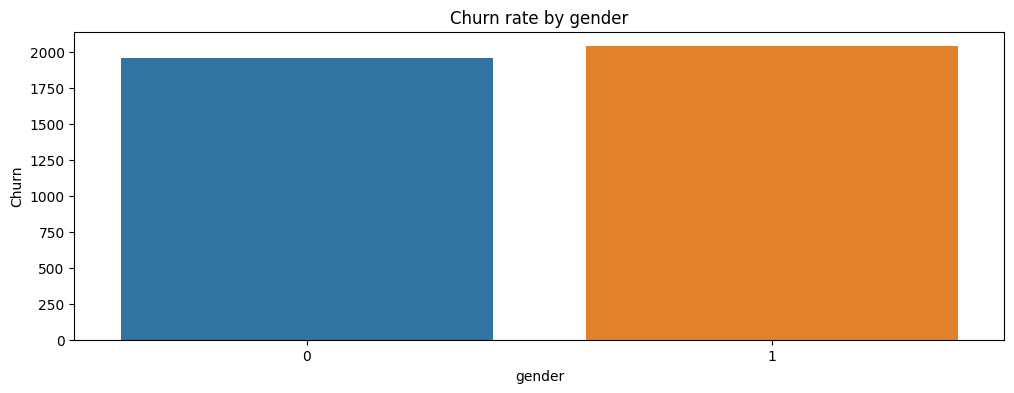

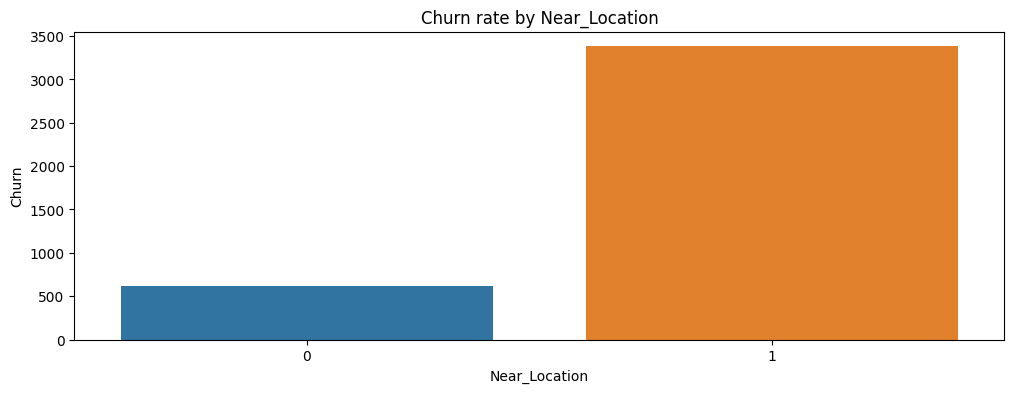

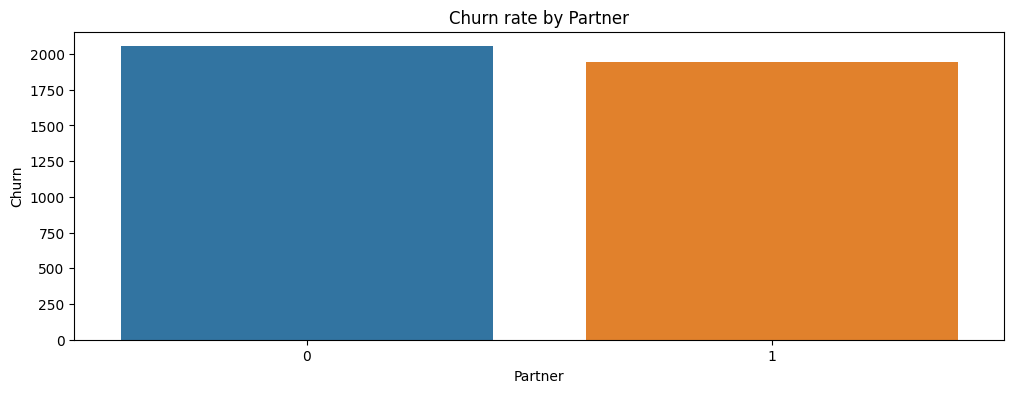

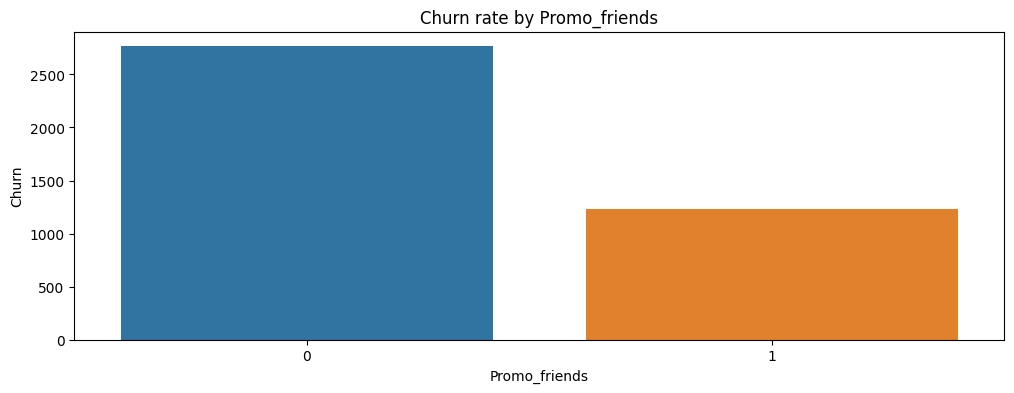

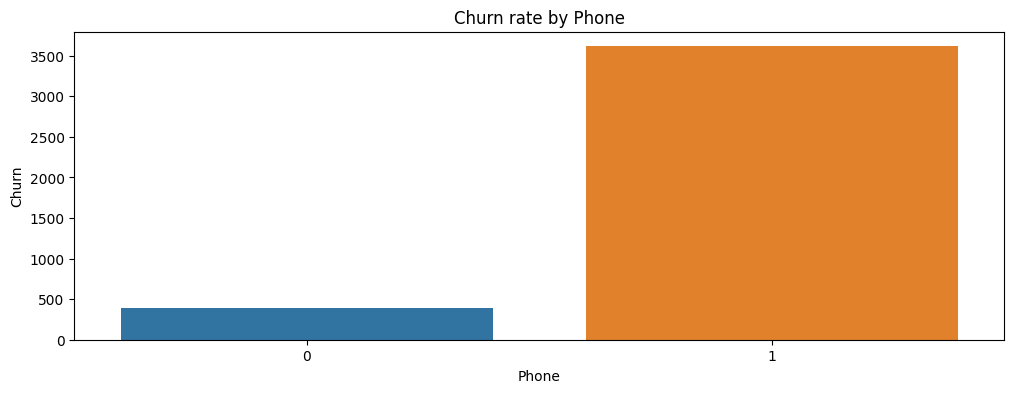

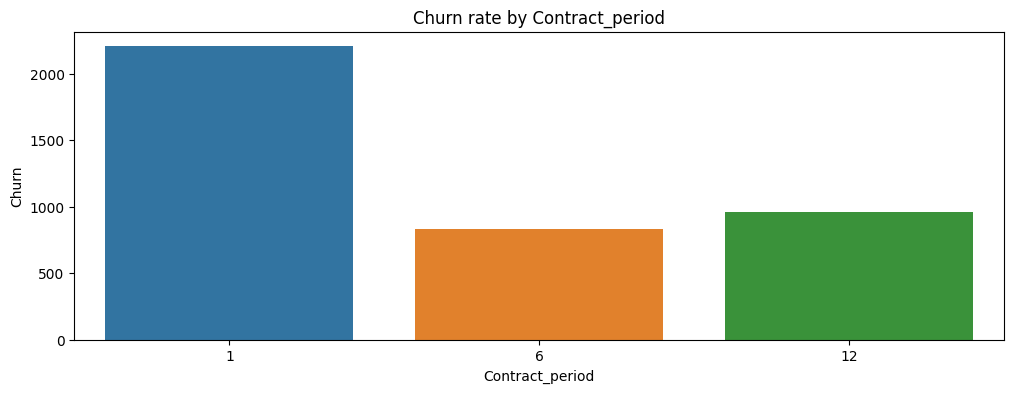

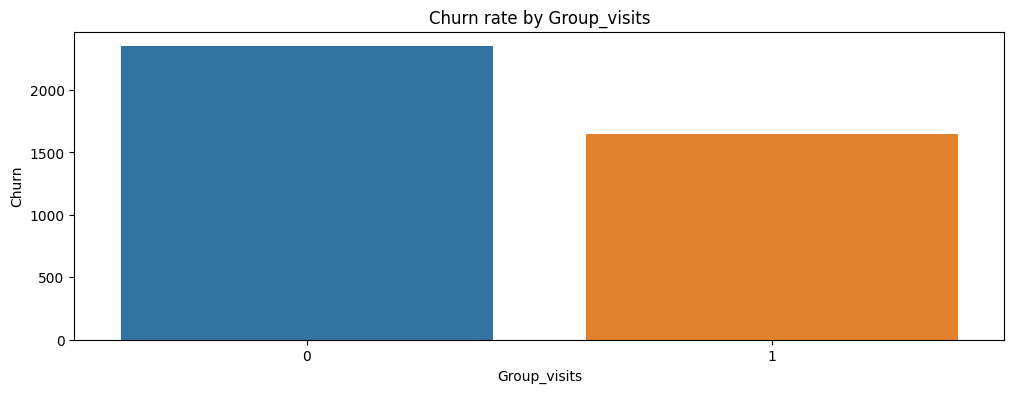

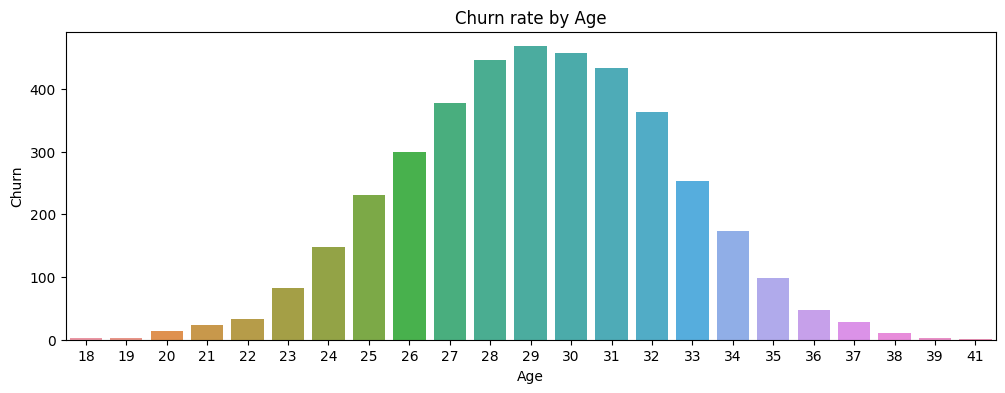

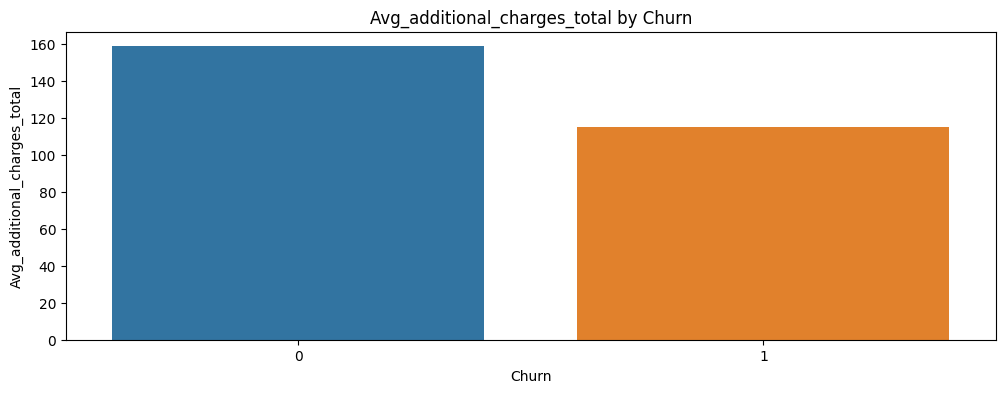

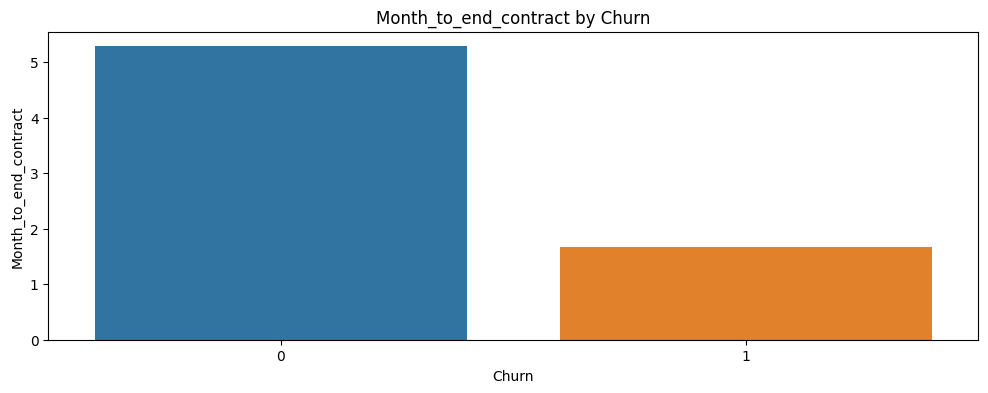

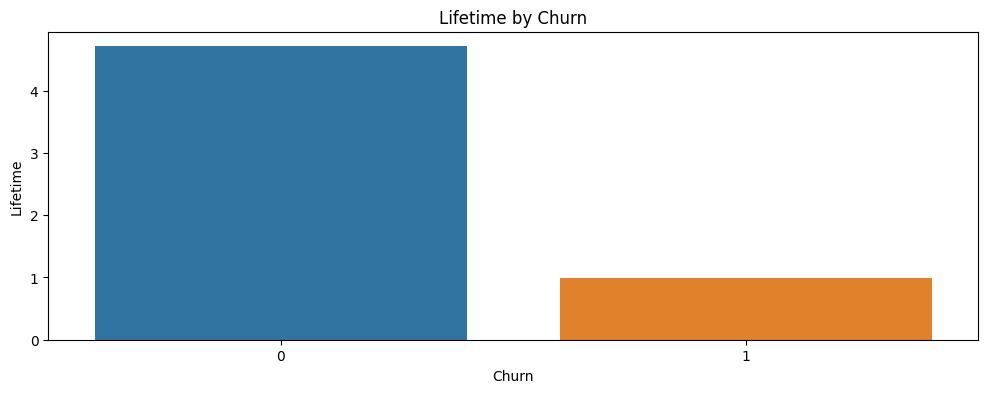

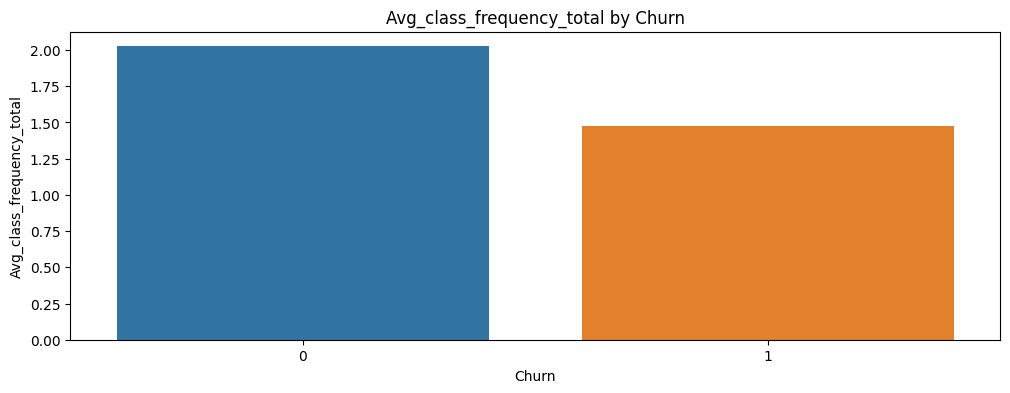

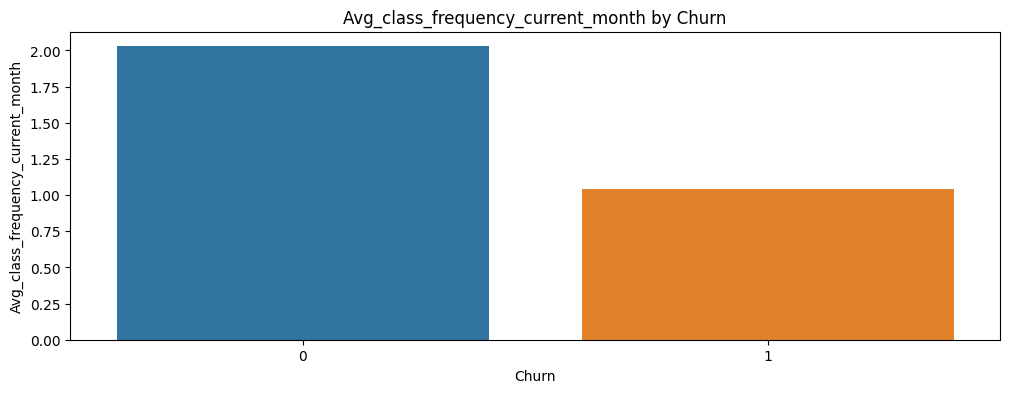

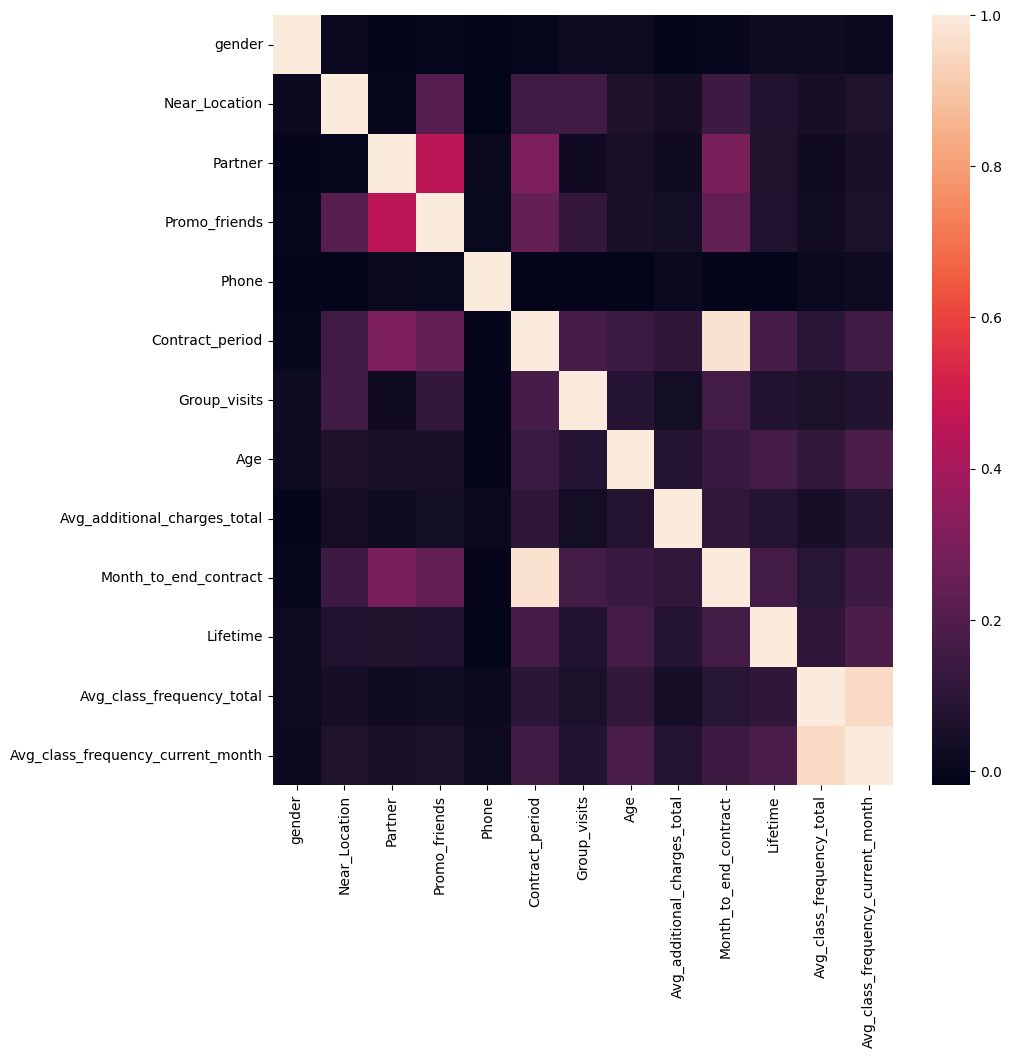

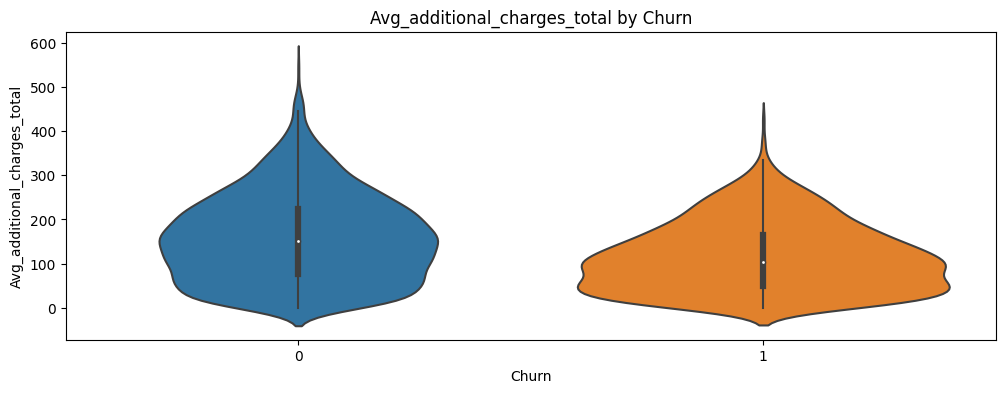

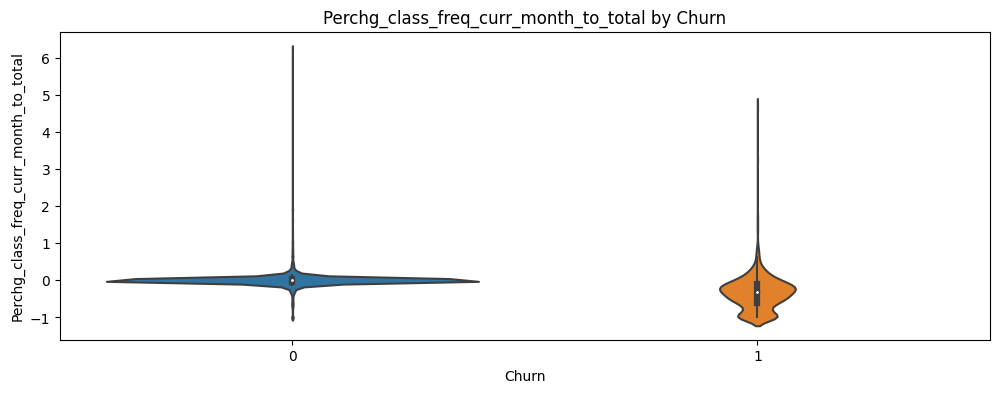

In [145]:
plot_single_feature(df, 'gender')
plot_single_feature(df, 'Near_Location')
plot_single_feature(df, 'Partner')
plot_single_feature(df, 'Promo_friends')
plot_single_feature(df, 'Phone')
plot_single_feature(df, 'Contract_period')
plot_single_feature(df, 'Group_visits')
plot_single_feature(df, 'Age')

plot_measures_by_churn(df, 'Avg_additional_charges_total', sns.barplot)
plot_measures_by_churn(df, 'Month_to_end_contract', sns.barplot)
plot_measures_by_churn(df, 'Lifetime', sns.barplot)
plot_measures_by_churn(df, 'Avg_class_frequency_total', sns.barplot)
plot_measures_by_churn(df, 'Avg_class_frequency_current_month', sns.barplot)

plot_corr_plot(df)

plot_measures_by_churn(df2, 'Avg_additional_charges_total', sns.violinplot, data_process='replace')
plot_measures_by_churn(df2, 'Perchg_class_freq_curr_month_to_total', sns.violinplot, data_process='replace')